In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import wandb

# TitanicDataset 클래스는 PyTorch의 Dataset을 상속받아 데이터셋을 정의
class TitanicDataset(Dataset):
  # 생성자: X(특징 데이터)와 y(타겟 데이터)를 텐서로 변환하여 초기화
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)  # X 데이터를 FloatTensor로 변환
    self.y = torch.LongTensor(y)   # y 데이터를 LongTensor로 변환

  # 데이터셋의 크기 반환
  def __len__(self):
    return len(self.X)  # X 데이터셋의 길이 반환

  # 주어진 인덱스의 데이터를 딕셔너리 형태로 반환
  def __getitem__(self, idx):
    feature = self.X[idx]  # X에서 해당 인덱스의 특징 데이터 선택
    target = self.y[idx]   # y에서 해당 인덱스의 타겟 데이터 선택
    return {'input': feature, 'target': target}  # 입력과 타겟 데이터를 반환

  # 데이터셋의 크기와 입력, 타겟 데이터의 모양을 문자열로 반환
  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


class TitanicTestDataset(Dataset):
    # 생성자: 입력 데이터를 받아 텐서로 변환
    def __init__(self, X):
        self.X = torch.FloatTensor(X)  # 입력 데이터를 FloatTensor로 변환

    # 데이터셋의 크기 반환
    def __len__(self):
        return len(self.X)

    # 주어진 인덱스의 데이터를 반환
    def __getitem__(self, idx):
        feature = self.X[idx]  # X에서 해당 인덱스의 특징 데이터 선택
        return {'input': feature}  # 입력 데이터를 딕셔너리 형태로 반환

    # 데이터셋의 크기와 입력 데이터의 모양을 문자열로 반환
    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}".format(
            len(self.X), self.X.shape  # 데이터 크기와 텐서의 모양을 문자열로 반환
        )
        return str 


In [2]:
def get_preprocessed_dataset():
    # 데이터 파일 경로 설정
    train_data_path = "train.csv"
    test_data_path = "test.csv"

    # CSV 파일을 읽어서 DataFrame으로 변환
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 훈련 데이터와 테스트 데이터를 하나의 DataFrame으로 결합
    all_df = pd.concat([train_df, test_df], sort=False)

    # 데이터 전처리 함수들을 순차적으로 적용
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # 생존 여부(Survived)가 있는 데이터는 훈련 데이터로 사용
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    # 생존 여부(Survived)가 없는 데이터는 테스트 데이터로 사용
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # TitanicDataset 클래스에 훈련 데이터를 입력해 데이터셋 객체 생성
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)

    # 훈련 데이터를 80:20 비율로 훈련/검증 데이터셋으로 분할
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])

    # 테스트 데이터셋 생성
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)


    # 훈련, 검증, 테스트 데이터셋 반환
    return train_dataset, validation_dataset, test_dataset


In [3]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()  # Pclass별 평균 Fare 계산
    Fare_mean.columns = ["Pclass", "Fare_mean"]  # 컬럼 이름 변경
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")  # 원본 데이터프레임과 평균값 병합
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]  # 결측치에 Pclass별 평균 Fare 삽입

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)  # Name 컬럼을 구분자로 분리
    name_df.columns = ["family_name", "honorific", "name"]  # 새로운 컬럼 이름 정의
    name_df["family_name"] = name_df["family_name"].str.strip()  # family_name 공백 제거
    name_df["honorific"] = name_df["honorific"].str.strip()  # honorific 공백 제거
    name_df["name"] = name_df["name"].str.strip()  # name 공백 제거
    all_df = pd.concat([all_df, name_df], axis=1)  # 원본 데이터프레임과 분리된 데이터프레임 병합

    return all_df


def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()  # honorific별 Age 중앙값 계산
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]  # 컬럼 이름 변경
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")  # 원본 데이터프레임과 중앙값 병합
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]  # 결측치에 honorific별 중앙값 삽입
    all_df = all_df.drop(["honorific_age_mean"], axis=1)  # 필요없는 컬럼 제거

    return all_df

In [4]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]  # 부모/자식 수와 형제/배우자 수를 합하여 가족 수 계산

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1  # 가족이 없으면 '혼자탑승'을 1로 설정
    all_df = all_df.assign(alone=all_df["alone"].fillna(0))  # fillna를 통해 결측값을 0으로 설정하고, assign으로 원본 데이터프레임에 적용

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)  # 불필요한 컬럼 제거

    return all_df


def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |  # Mr가 아닌
            (all_df["honorific"] == "Miss") |  # Miss가 아닌
            (all_df["honorific"] == "Mrs") |  # Mrs가 아닌
            (all_df["honorific"] == "Master")  # Master가 아닌
    ),
    "honorific"
    ] = "other"  # 그 외 honorific 값은 'other'로 변경
    all_df = all_df.assign(Embarked=all_df["Embarked"].fillna("missing"))  # Embarked 결측값을 'missing'으로 설정

    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]  # 문자열 데이터형을 가진 컬럼들 선택
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()  # LabelEncoder 객체 생성
        if all_df[category_feature].dtypes == "object":  # 각 카테고리 변수를 수치로 변환
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])  # 변환된 값을 DataFrame에 저장

    return all_df


In [5]:
from torch import nn

# 모델 클래스 수정, 활성화 함수 변경 가능
class MyModel(nn.Module):
  def __init__(self, n_input, n_output, activation_fn=nn.ReLU):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      activation_fn(),  # 동적으로 activation_fn 적용
      nn.Linear(30, 30),
      activation_fn(),  # 동적으로 activation_fn 적용
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [6]:
# Wandb를 통한 학습 및 로깅
def train_and_validate_model(activation_fn, log_epochs=False):
    # Wandb 초기화: 프로젝트 이름과 활성화 함수 이름을 기록
    run = wandb.init(project="titanic-activation", config={
        "activation_function": activation_fn.__name__  # 현재 사용 중인 활성화 함수 이름을 기록
    })

    # 모델 초기화
    model = MyModel(n_input=11, n_output=2, activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()  # 손실 함수 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화기 설정

    # 데이터셋 로드
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)  # 훈련 데이터 로더
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=False)  # 검증 데이터 로더

    num_epochs = 300  # 에포크 수 설정
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss = 0.0  # 훈련 손실 초기화
        for batch in train_data_loader:
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(batch['input'])  # 모델을 통해 예측값 생성
            loss = criterion(outputs, batch['target'])  # 손실 계산
            loss.backward()  # 역전파 수행
            optimizer.step()  # 파라미터 업데이트
            train_loss += loss.item()  # 훈련 손실 누적

        train_loss /= len(train_data_loader)  # 평균 훈련 손실 계산

        model.eval()  # 모델을 평가 모드로 설정
        validation_loss = 0.0  # 검증 손실 초기화
        with torch.no_grad():  # 기울기 계산 비활성화
            for batch in validation_data_loader:
                outputs = model(batch['input'])  # 검증 데이터로 예측값 생성
                loss = criterion(outputs, batch['target'])  # 손실 계산
                validation_loss += loss.item()  # 검증 손실 누적

        validation_loss /= len(validation_data_loader)  # 평균 검증 손실 계산

        # Wandb에 에포크별 손실 기록
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "validation_loss": validation_loss
        })

        # log_epochs가 True일 때만 에포크 정보 출력
        if log_epochs:
            print(f"Epoch : [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")

    # 훈련 종료 후 Wandb 대시보드 URL 출력
    print(f"Wandb dashboard URL: {run.url}")  # 사용자가 Wandb 대시보드에서 결과를 확인할 수 있도록 URL 제공
    
    wandb.finish()  # Wandb 세션 종료

    return model, validation_loss  # 훈련된 모델과 검증 손실 반환

In [7]:
# 제출 파일 생성 함수
def create_submission(test_data_loader, model, submission_file='submission.csv'): 
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_data_loader:
            outputs = model(batch['input'])
            prediction_batch = torch.argmax(outputs, dim=1)
            predictions.extend(prediction_batch.cpu().numpy())

    # 지정된 경로에 submission.csv 생성
    submission_df = pd.DataFrame({'PassengerId': range(892, 892 + len(predictions)), 'Survived': predictions})

    submission_df.to_csv(submission_file, index=False)
    print(f"제출파일'{submission_file}' 생성.")

In [8]:
if __name__ == "__main__":

    # 실험할 활성화 함수들 정의
    activation_functions = [nn.ReLU, nn.ELU, nn.LeakyReLU, nn.PReLU]

    best_model = None
    best_validation_loss = float('inf')  # 초기값은 무한대로 설정

    # 각 활성화 함수에 대해 학습을 실행
    for activation_fn in activation_functions:
        model, validation_loss = train_and_validate_model(activation_fn)  # 학습 후 모델과 검증 손실 반환
        
        # 최적 모델 업데이트
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model = model

    # 최적 모델의 활성화 함수 타입을 추출하여 사용
    best_activation_fn = type(best_model.model[1])

    # 최적 모델에 대해 다시 학습을 실행하고 로그 출력 (log_epochs=True 설정)
    print("\nBest Model Training Logs:\n")
    model, validation_loss = train_and_validate_model(best_activation_fn, log_epochs=True)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: onionring4028 (onionring4028-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


Wandb dashboard URL: https://wandb.ai/onionring4028-korea-university-of-technology-and-education/titanic-activation/runs/jztvid1v


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▇▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁
validation_loss,▆▆▄▂▄▁▁▁▃▃▂▂▂▃▅▂▂▂▂▂▄▂▃▃▃▂▄▄▃▄▄▄▄▅▇▄▅▇█▆
epoch,299
train_loss,0.28811
validation_loss,0.54274


Wandb dashboard URL: https://wandb.ai/onionring4028-korea-university-of-technology-and-education/titanic-activation/runs/73xu4xqo


epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
train_loss,█▆▆▆▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
validation_loss,▆▅▇▅▄▄▃█▃▃▄▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▂▂▃▂▂▃▄▄▅▅
epoch,299
train_loss,0.30447
validation_loss,0.44481


Wandb dashboard URL: https://wandb.ai/onionring4028-korea-university-of-technology-and-education/titanic-activation/runs/4k54msd3


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇████
train_loss,█▅▅▃▃▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
validation_loss,▅▅▄▄▄▃▂▂▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▃▂▃▄▄▅▅▆▆▇▇▆▇█
epoch,299
train_loss,0.29741
validation_loss,0.77599


Wandb dashboard URL: https://wandb.ai/onionring4028-korea-university-of-technology-and-education/titanic-activation/runs/sv9vlocb


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▅▅▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
validation_loss,▇▆▅▄▅▃▅▄▂▅▂▂▃▁▂▂█▂▂▁▁▁▂▄▃▅▃▄▅▄▅▆▄▆▄▆▅▅▅▆
epoch,299
train_loss,0.30315
validation_loss,0.48307



Best Model Training Logs:



Epoch : [1/300], Train Loss: 0.7129, Validation Loss: 0.5166
Epoch : [2/300], Train Loss: 0.5934, Validation Loss: 0.5111
Epoch : [3/300], Train Loss: 0.5803, Validation Loss: 0.5022
Epoch : [4/300], Train Loss: 0.5727, Validation Loss: 0.5091
Epoch : [5/300], Train Loss: 0.5615, Validation Loss: 0.4874
Epoch : [6/300], Train Loss: 0.5748, Validation Loss: 0.4939
Epoch : [7/300], Train Loss: 0.5485, Validation Loss: 0.4748
Epoch : [8/300], Train Loss: 0.5395, Validation Loss: 0.4667
Epoch : [9/300], Train Loss: 0.5337, Validation Loss: 0.4795
Epoch : [10/300], Train Loss: 0.5230, Validation Loss: 0.4552
Epoch : [11/300], Train Loss: 0.5188, Validation Loss: 0.4579
Epoch : [12/300], Train Loss: 0.5071, Validation Loss: 0.4223
Epoch : [13/300], Train Loss: 0.4902, Validation Loss: 0.4213
Epoch : [14/300], Train Loss: 0.4887, Validation Loss: 0.4135
Epoch : [15/300], Train Loss: 0.4789, Validation Loss: 0.4236
Epoch : [16/300], Train Loss: 0.4776, Validation Loss: 0.4365
Epoch : [17/300],

epoch,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_loss,██▇▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁
validation_loss,███▅▃▂▂▂▃▁▁▁▂▂▂▄▃▃▃▄▃▄▄▄▃▃▄▄▅▅▅▅▆▅▅▅▅▅▆▆
epoch,299
train_loss,0.29551
validation_loss,0.47439


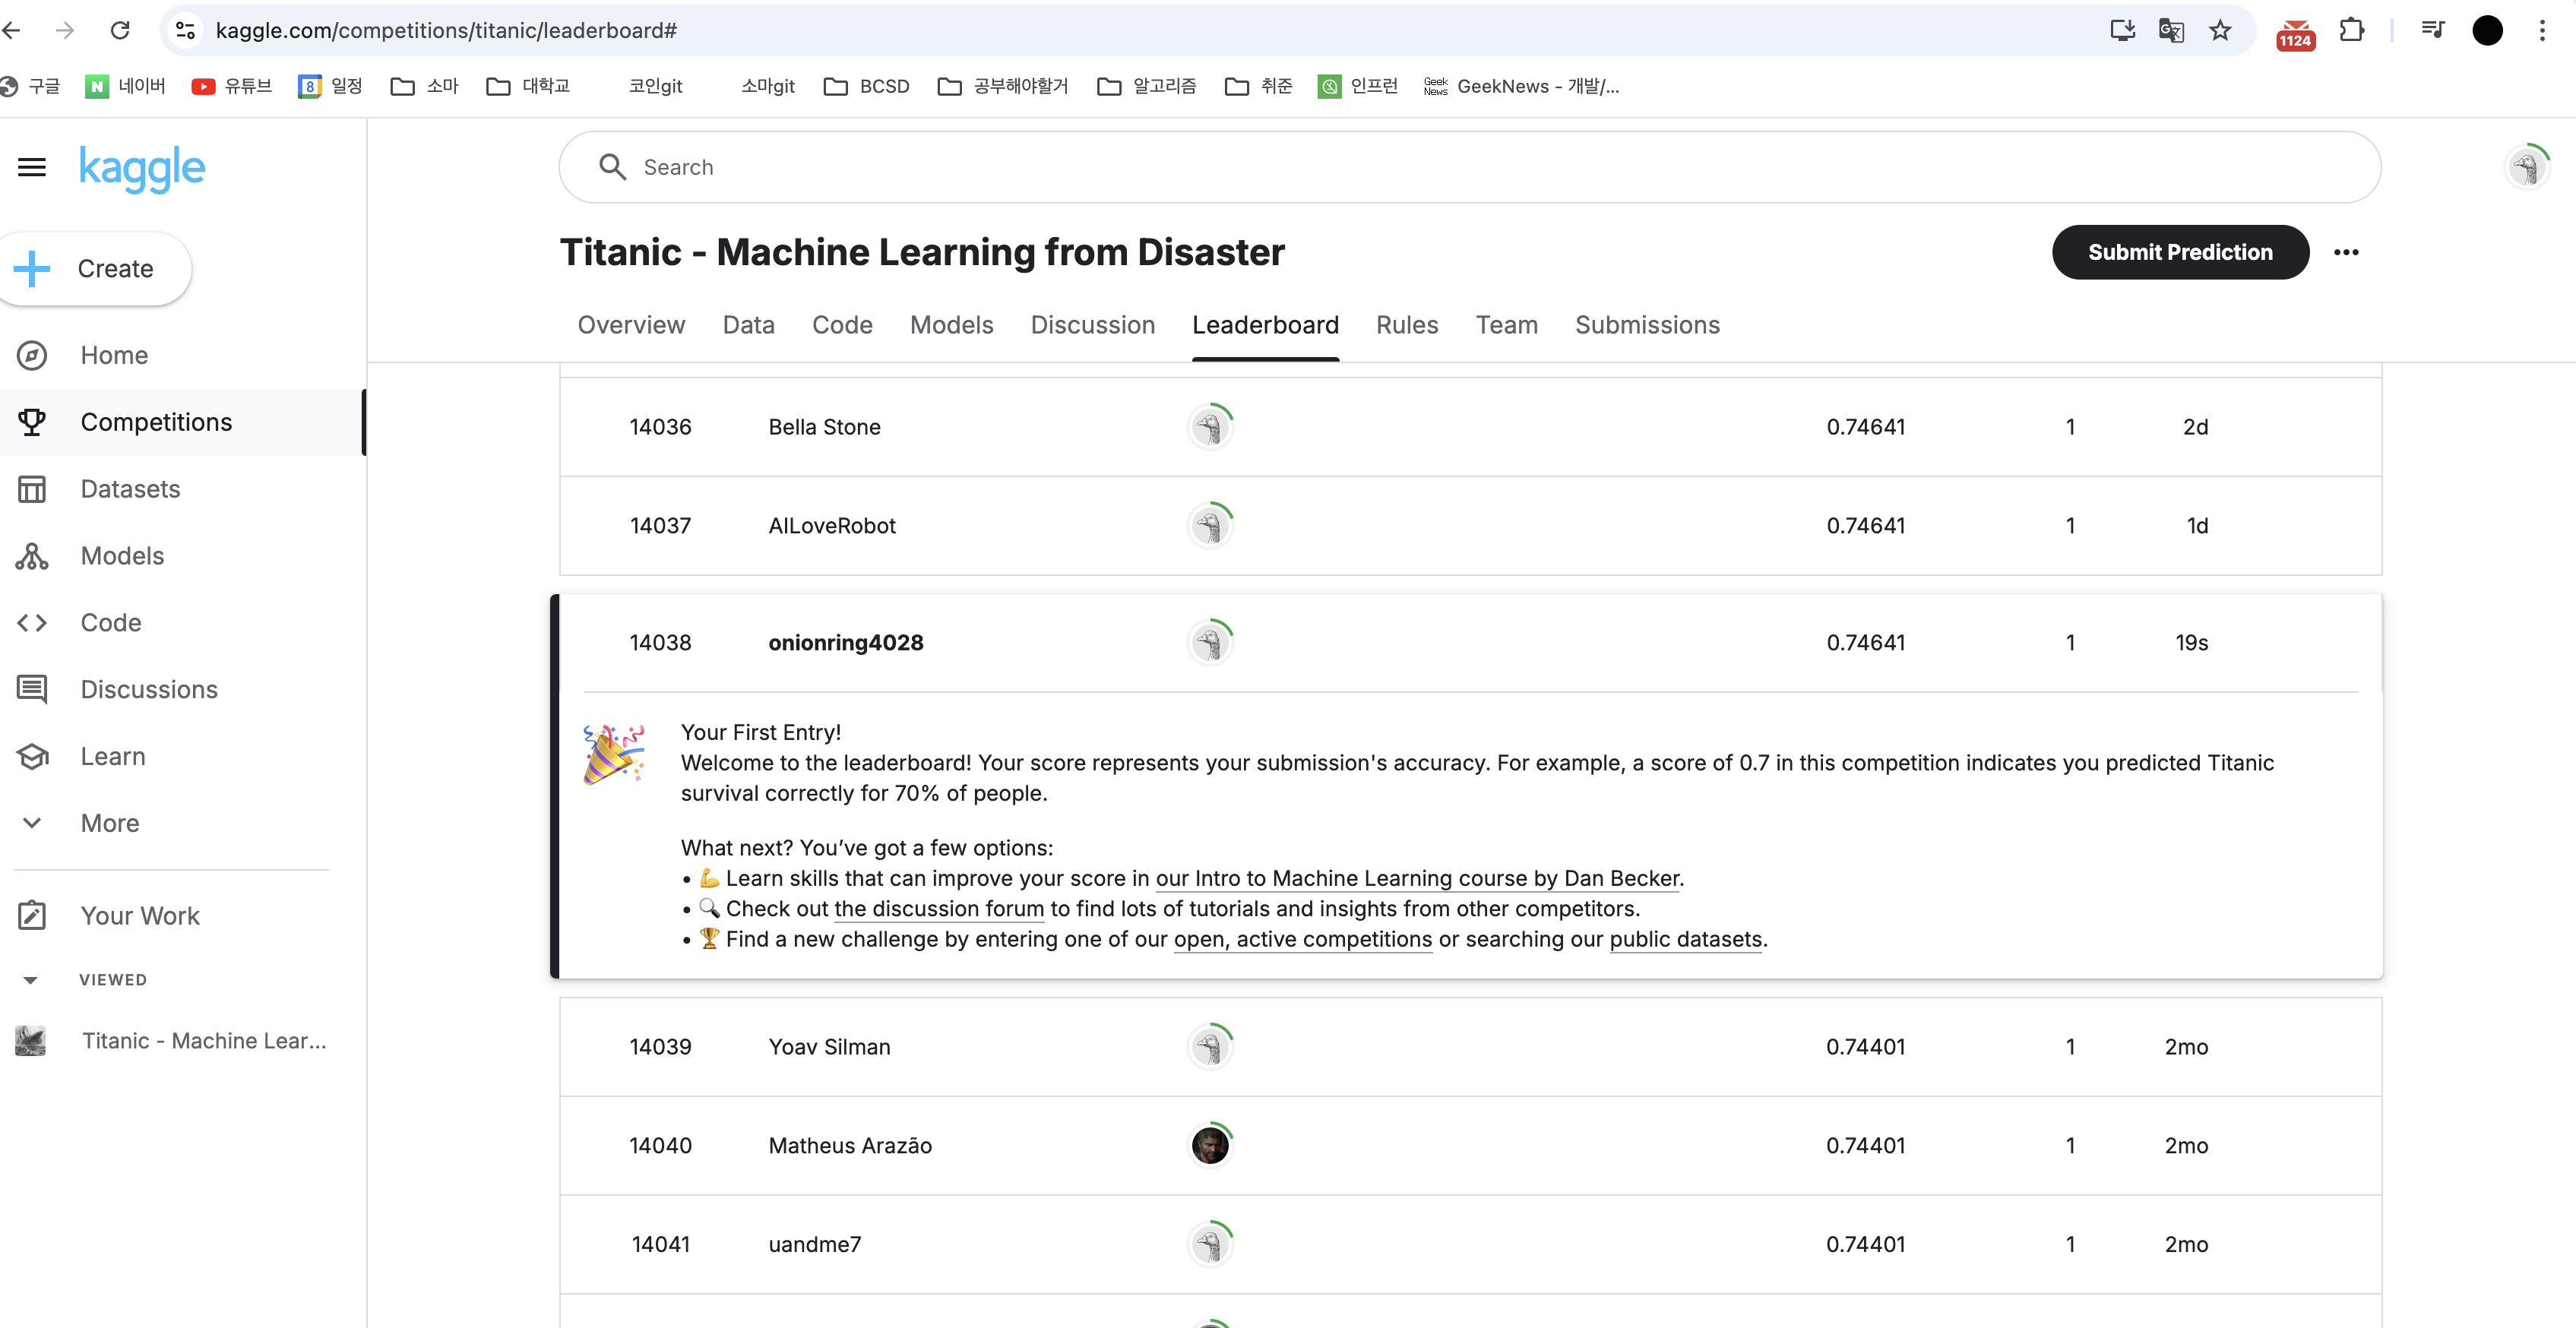

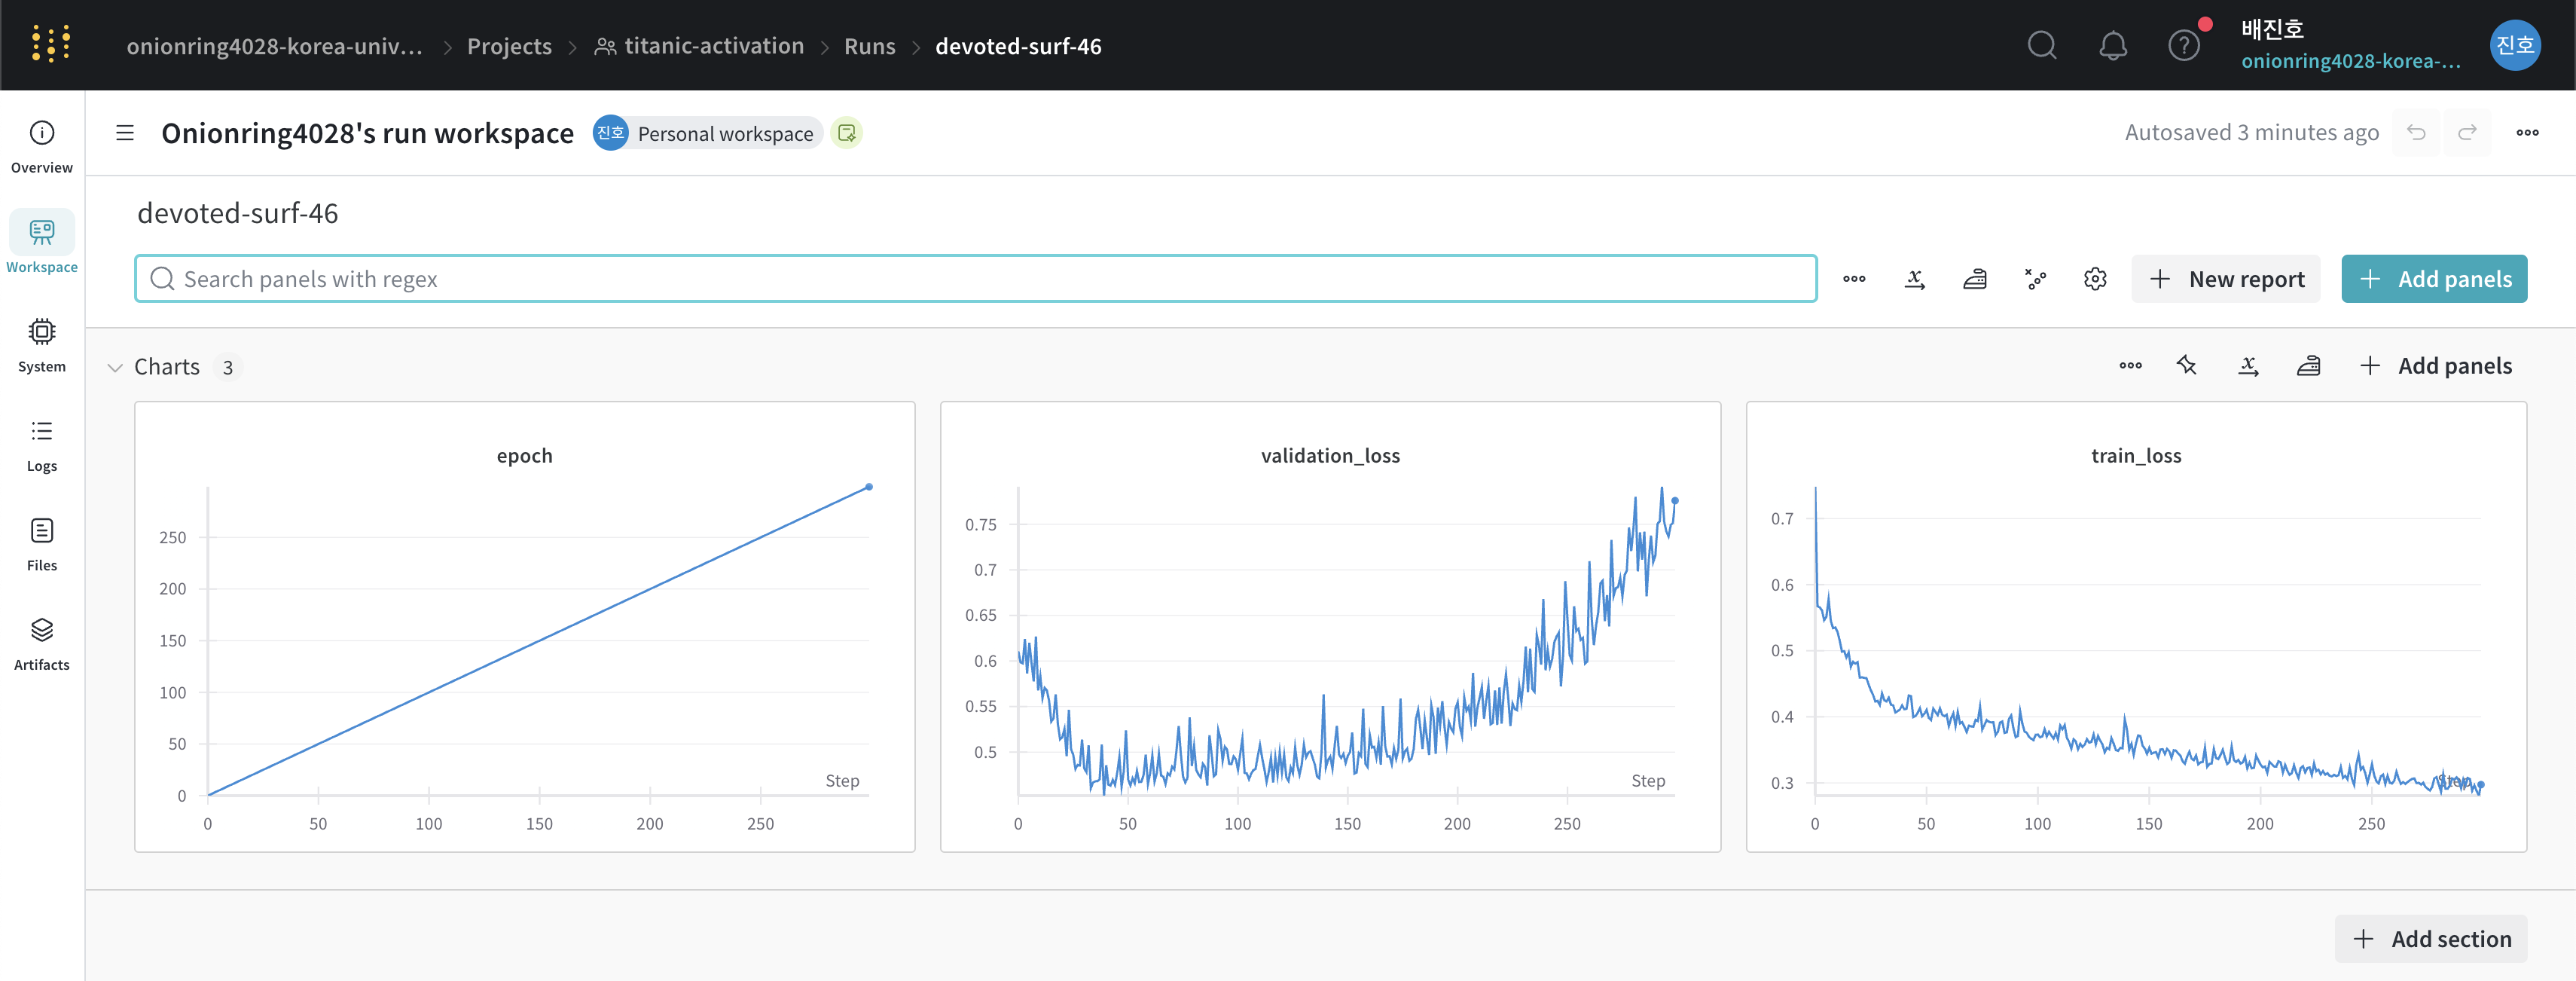

# 숙제 후기

validation_loss 그래프는 약 100 epoch 이후부터 점진적으로 증가하고 있으며, 이 시점 이후부터는 검증 손실이 증가하는 반면, 훈련 손실(train_loss)은 계속해서 감소하고 있습니다. 이는 모델이 훈련 데이터에 과적합되기 시작했다는 것을 의미합니다.
따라서, overfitting은 약 100 epoch부터 발생했다고 볼 수 있습니다

평소 알고리즘을 좋아해서 온라인 알고리즘 문제 사이트에서 문제를 풀고는 했는데, 이런 머신러닝으로도 경쟁할 수 있다는 것이 신기했습니다. 실제로 트레이닝 시키면서 오버피팅이 발생하는것을 보는도 매우 새로운 경험이었습니다.